# HOPE Pilot v2 - Interactive Chat

Load the latest checkpoint and chat with the model while training continues in the main notebook.

**Features:**
- Automatically loads latest checkpoint
- Works while training runs in parallel
- Simple interactive chat interface
- Configurable generation parameters

## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm
import numpy as np
import os
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Optional

# Device setup
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)
print(f"Using device: {device}")

# Paths
CHECKPOINT_DIR = "hope_pilot_v2_data/checkpoints"
TOKENIZER_DIR = "hope_pilot_v2_data/tokenizer"

print(f"✓ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✓ Tokenizer directory: {TOKENIZER_DIR}")

Using device: mps
✓ Checkpoint directory: hope_pilot_v2_data/checkpoints
✓ Tokenizer directory: hope_pilot_v2_data/tokenizer


## 2. Model Architecture

Define the same HOPE architecture as the training notebook.

In [2]:
@dataclass
class PilotConfig:
    """HOPE Pilot model configuration - matches training notebook"""
    # Architecture
    vocab_size: int = 32000
    dim: int = 512
    num_layers: int = 12
    heads: int = 8
    seq_len: int = 512
    
    # Training (not needed for inference, but included for compatibility)
    batch_size: int = 1
    total_steps: int = 0
    save_interval: int = 1000

class SelfAttention(nn.Module):
    """Multi-head self-attention with causal masking"""
    
    def __init__(self, dim: int, heads: int):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        
        self.qkv = nn.Linear(dim, 3 * dim, bias=False)
        self.out = nn.Linear(dim, dim, bias=False)
    
    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.heads, self.head_dim)
        q, k, v = qkv.unbind(dim=2)
        
        # Use Flash Attention if available
        attn_out = F.scaled_dot_product_attention(
            q.transpose(1, 2),
            k.transpose(1, 2),
            v.transpose(1, 2),
            is_causal=True
        )
        
        attn_out = attn_out.transpose(1, 2).reshape(B, T, C)
        return self.out(attn_out)


class TitanMemory(nn.Module):
    """TITAN fast associative memory"""
    
    def __init__(self, dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim, bias=False),
            nn.GELU(),
            nn.Linear(4 * dim, dim, bias=False)
        )
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        return self.mlp(self.norm(x))


class CMSBlock(nn.Module):
    """Continuum Memory System block"""
    
    def __init__(self, dim: int):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim, bias=False),
            nn.GELU(),
            nn.Linear(4 * dim, dim, bias=False)
        )
    
    def forward(self, x):
        return x + self.mlp(self.norm(x))


class HOPEBlock(nn.Module):
    """HOPE block: Attention + TITAN + 4-level CMS"""
    
    def __init__(self, dim: int, heads: int):
        super().__init__()
        self.attn = SelfAttention(dim, heads)
        self.attn_norm = nn.LayerNorm(dim)
        
        self.titan = TitanMemory(dim)
        
        # 4 CMS levels (Pilot configuration)
        self.cms_fast = CMSBlock(dim)
        self.cms_mid = CMSBlock(dim)
        self.cms_slow = CMSBlock(dim)
        self.cms_ultra = CMSBlock(dim)
    
    def forward(self, x):
        # Self-attention
        attn_out = self.attn(self.attn_norm(x))
        x = x + attn_out
        
        # TITAN memory
        mem_out = self.titan(x)
        x = x + mem_out
        
        # 4-level CMS hierarchy
        x = self.cms_fast(x)
        x = self.cms_mid(x)
        x = self.cms_slow(x)
        x = self.cms_ultra(x)
        
        return x


class HOPEPilotModel(nn.Module):
    """HOPE Pilot Model (155M parameters)"""
    
    def __init__(self, config: PilotConfig):
        super().__init__()
        self.config = config
        
        # Token embeddings
        self.embedding = nn.Embedding(config.vocab_size, config.dim)
        
        # HOPE blocks
        self.blocks = nn.ModuleList([
            HOPEBlock(config.dim, config.heads)
            for _ in range(config.num_layers)
        ])
        
        # Output layers
        self.ln_f = nn.LayerNorm(config.dim)
        self.lm_head = nn.Linear(config.dim, config.vocab_size, bias=False)  # FIXED: correct dimensions
        
        # Weight tying
        self.lm_head.weight = self.embedding.weight
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, tokens):
        x = self.embedding(tokens)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("✓ Model architecture defined (matches training notebook)")

✓ Model architecture defined (matches training notebook)


## 3. Load Latest Checkpoint

Automatically finds and loads the most recent checkpoint.

In [3]:
def find_latest_checkpoint(checkpoint_dir: str) -> Optional[str]:
    """Find the latest checkpoint file"""
    ckpt_files = list(Path(checkpoint_dir).glob("step_*.pt"))
    if not ckpt_files:
        return None
    
    # Sort by step number
    ckpt_files.sort(key=lambda x: int(x.stem.split('_')[-1]))
    return str(ckpt_files[-1])

# Find latest checkpoint
latest_ckpt = find_latest_checkpoint(CHECKPOINT_DIR)

if latest_ckpt is None:
    print("❌ No checkpoint found! Train the model first.")
    raise FileNotFoundError(f"No checkpoints in {CHECKPOINT_DIR}")

print(f"Found checkpoint: {latest_ckpt}")

# Load checkpoint
checkpoint = torch.load(latest_ckpt, map_location=device)

# Extract config from checkpoint - only the fields that exist
config = PilotConfig(
    vocab_size=checkpoint['config'].get('vocab_size', 32000),
    dim=checkpoint['config'].get('dim', 512),
    num_layers=checkpoint['config'].get('num_layers', 12),
    heads=checkpoint['config'].get('heads', 8),
    seq_len=checkpoint['config'].get('seq_len', 512),
    batch_size=checkpoint['config'].get('batch_size', 1),
    total_steps=checkpoint['config'].get('total_steps', 0),
    save_interval=checkpoint['config'].get('save_interval', 1000)
)

print(f"\n{'='*60}")
print("CHECKPOINT INFO")
print(f"{'='*60}")
print(f"Step: {checkpoint['step']:,}")
print(f"Loss: {checkpoint['metrics']['loss']:.4f}")
print(f"Perplexity: {checkpoint['metrics']['ppl']:.2f}")
print(f"Model: {config.num_layers} layers, {config.dim} dim, {config.heads} heads")
print(f"Parameters: ~{sum(p.numel() for p in checkpoint['model'].values()) / 1e6:.1f}M")
print(f"{'='*60}\n")

# Create model and load weights
model = HOPEPilotModel(config).to(device)
model.load_state_dict(checkpoint['model'])
model.eval()

print("✓ Model loaded and ready for inference")

Found checkpoint: hope_pilot_v2_data/checkpoints/step_246667.pt

CHECKPOINT INFO
Step: 246,667
Loss: 2.5892
Perplexity: 13.32
Model: 12 layers, 512 dim, 8 heads
Parameters: ~171.3M

✓ Model loaded and ready for inference


## 4. Load Tokenizer

In [4]:
tokenizer_path = f"{TOKENIZER_DIR}/spm_32000_unigram.model"

if not os.path.exists(tokenizer_path):
    print(f"❌ Tokenizer not found at {tokenizer_path}")
    raise FileNotFoundError("Train the tokenizer first in the main notebook")

sp = spm.SentencePieceProcessor()
sp.load(tokenizer_path)

print(f"✓ Tokenizer loaded: {sp.vocab_size()} tokens")
print(f"  BOS token: {sp.bos_id()}")
print(f"  EOS token: {sp.eos_id()}")
print(f"  PAD token: {sp.pad_id()}")

✓ Tokenizer loaded: 32000 tokens
  BOS token: 1
  EOS token: 2
  PAD token: -1


## 5. Generation Functions

In [5]:
@torch.no_grad()
def generate(
    prompt: str,
    max_new_tokens: int = 100,
    temperature: float = 0.8,
    top_k: int = 50,
    top_p: float = 0.9,
    repetition_penalty: float = 1.1
) -> str:
    """
    Generate text from a prompt.
    
    Args:
        prompt: Input text
        max_new_tokens: Maximum tokens to generate
        temperature: Sampling temperature (higher = more random)
        top_k: Keep only top k tokens for sampling
        top_p: Nucleus sampling threshold
        repetition_penalty: Penalty for repeating tokens (> 1.0 = less repetition)
    """
    model.eval()
    
    # Encode prompt
    tokens = sp.encode(prompt, add_bos=True)
    tokens = torch.tensor([tokens], dtype=torch.long, device=device)
    
    # Track generated tokens for repetition penalty
    generated_tokens = tokens[0].tolist()
    
    for _ in range(max_new_tokens):
        # Get predictions (only use last seq_len tokens if prompt is too long)
        if tokens.size(1) > config.seq_len:
            input_tokens = tokens[:, -config.seq_len:]
        else:
            input_tokens = tokens
        
        logits = model(input_tokens)
        logits = logits[0, -1, :]  # Get last token logits
        
        # Apply repetition penalty
        if repetition_penalty != 1.0:
            for token_id in set(generated_tokens):
                logits[token_id] /= repetition_penalty
        
        # Apply temperature
        logits = logits / temperature
        
        # Top-k filtering
        if top_k > 0:
            top_k_values, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < top_k_values[-1]] = float('-inf')
        
        # Top-p (nucleus) filtering
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            
            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = False
            
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[indices_to_remove] = float('-inf')
        
        # Sample
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Check for EOS
        if next_token.item() == sp.eos_id():
            break
        
        # Append to sequence
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
        generated_tokens.append(next_token.item())
    
    # Decode
    output = sp.decode(tokens[0].tolist())
    return output

print("✓ Generation functions ready")

✓ Generation functions ready


## 6. Interactive Chat

Chat with the model! Type your prompts and get responses.

**Commands:**
- Type your prompt and press Enter to generate
- Type `quit` or `exit` to stop
- Type `reload` to load the latest checkpoint (useful if training saved a new one)
- Type `config` to see/change generation settings

In [9]:
# Default generation settings
gen_config = {
    'max_new_tokens': 150,
    'temperature': 0.2,
    'top_k': 50,
    'top_p': 0.9,
    'repetition_penalty': 1.1
}

print("="*60)
print("HOPE PILOT v2 - INTERACTIVE CHAT")
print("="*60)
print(f"Loaded checkpoint from step {checkpoint['step']:,}")
print(f"Loss: {checkpoint['metrics']['loss']:.4f} | Perplexity: {checkpoint['metrics']['ppl']:.2f}")
print("\nCommands:")
print("  'quit' or 'exit' - Exit chat")
print("  'reload' - Load latest checkpoint")
print("  'config' - Show/change generation settings")
print("="*60)
print()

while True:
    try:
        prompt = input("\n🧑 You: ").strip()
        
        if not prompt:
            continue
        
        if prompt.lower() in ['quit', 'exit']:
            print("\n👋 Goodbye!")
            break
        
        if prompt.lower() == 'reload':
            latest_ckpt = find_latest_checkpoint(CHECKPOINT_DIR)
            if latest_ckpt:
                checkpoint = torch.load(latest_ckpt, map_location=device)
                model.load_state_dict(checkpoint['model'])  # FIXED: use 'model' not 'model_state_dict'
                print(f"✓ Reloaded checkpoint from step {checkpoint['step']:,}")
                print(f"  Loss: {checkpoint['metrics']['loss']:.4f} | Perplexity: {checkpoint['metrics']['ppl']:.2f}")
            else:
                print("❌ No checkpoint found")
            continue
        
        if prompt.lower() == 'config':
            print("\nCurrent generation settings:")
            for key, value in gen_config.items():
                print(f"  {key}: {value}")
            print("\nTo change, modify the gen_config dictionary in the code cell above.")
            continue
        
        # Generate response
        print("\n🤖 HOPE Pilot: ", end="", flush=True)
        response = generate(prompt, **gen_config)
        
        # Extract only the new text (remove the prompt)
        if response.startswith(prompt):
            response = response[len(prompt):].strip()
        
        print(response)
    
    except KeyboardInterrupt:
        print("\n\n👋 Interrupted. Type 'quit' to exit or continue chatting.")
        continue
    except Exception as e:
        print(f"\n❌ Error: {e}")
        continue

HOPE PILOT v2 - INTERACTIVE CHAT
Loaded checkpoint from step 246,667
Loss: 2.5892 | Perplexity: 13.32

Commands:
  'quit' or 'exit' - Exit chat
  'reload' - Load latest checkpoint
  'config' - Show/change generation settings


🤖 HOPE Pilot: a great way to get the best quality of life.
The first day of the year was the last time I had to go to the next generation of the year, and then we went to the next generation of the year. The last thing I was going to do is that the next generation of the year was the last year, but the next generation of the year was the last year, and the next generation of the year was the last year.
I think it's not just the first time I'm going to be able to get the job done in the future. I'm going to get the job done in the future. I'm going to be able to get the job done in the future. I'

👋 Goodbye!


## 7. Quick Test Prompts

Run this cell to test the model with some example prompts without the interactive loop.

In [6]:
test_prompts = [
    "The capital of France is",
    "Once upon a time",
    "To be or not to be",
    "The meaning of life is",
    "In the beginning"
]

print("Testing model with example prompts...\n")
print("="*80)

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n[{i}/{len(test_prompts)}] Prompt: {prompt}")
    print("-" * 80)
    
    response = generate(
        prompt,
        max_new_tokens=50,
        temperature=0.2,
        top_k=40,
        top_p=0.9
    )
    
    print(response)
    print("="*80)

print("\n✓ Testing complete!")

Testing model with example prompts...


[1/5] Prompt: The capital of France is
--------------------------------------------------------------------------------
The capital of France is a popular among the finest and finest of Italians.

In the early 1990s, the municipality was established in the 1920s. In the late 1990s, the municipality was built up in the late 1990s. The municipality was built up

[2/5] Prompt: Once upon a time
--------------------------------------------------------------------------------
Once upon a time, he was a member of the United States Army. He was also a member of the American Legion of Honors of the Year award in the American Legion of Honors of the Year award.

In the 1950s, he was a member

[3/5] Prompt: To be or not to be
--------------------------------------------------------------------------------
To be or not to be used in the form of a single-part file.

A: You can also use this file to create a file from the file.

A: You can use this file to cre

## 8. View Training Progress

Check the latest metrics from the training run.

TRAINING PROGRESS
Total logged steps: 60

Last 5 checkpoints:
Step       Loss       Perplexity   Tokens/sec  
------------------------------------------------------------
2750       6.5822     722.10       2000        
2800       7.3358     1534.32      2000        
2850       6.1321     460.41       2010        
2900       6.1650     475.82       2011        
2950       5.7550     315.77       1997        


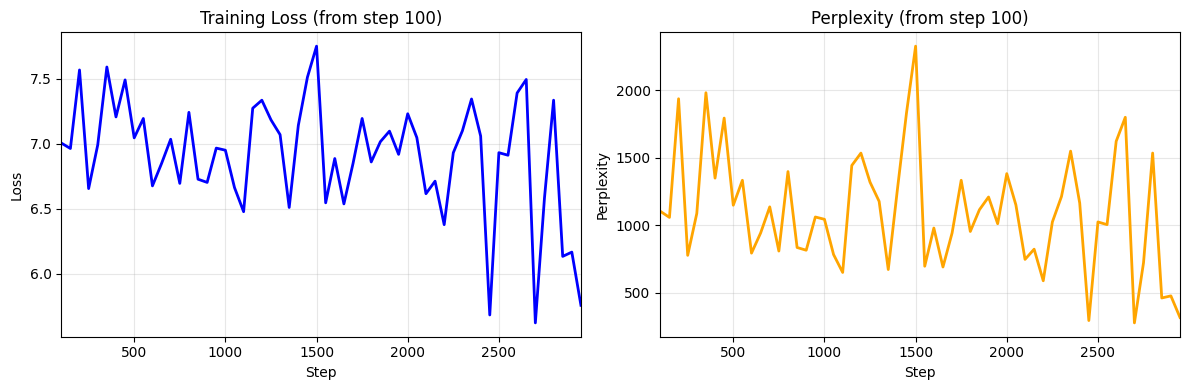

In [8]:
metrics_file = f"{CHECKPOINT_DIR}/metrics_history.json"

if os.path.exists(metrics_file):
    with open(metrics_file, 'r') as f:
        metrics_history = json.load(f)
    
    if metrics_history:
        print(f"{'='*60}")
        print("TRAINING PROGRESS")
        print(f"{'='*60}")
        print(f"Total logged steps: {len(metrics_history)}")
        print()
        
        # Show last 5 metrics
        print("Last 5 checkpoints:")
        print(f"{'Step':<10} {'Loss':<10} {'Perplexity':<12} {'Tokens/sec':<12}")
        print("-" * 60)
        
        for m in metrics_history[-5:]:
            print(f"{m['step']:<10} {m['loss']:<10.4f} {m['ppl']:<12.2f} {m['tokens_per_sec']:<12.0f}")
        
        print(f"{'='*60}")
        
        # Filter to only show steps >= 100 to reduce noise from early training
        filtered_metrics = [m for m in metrics_history if m['step'] >= 100]
        
        if filtered_metrics:
            # Plot metrics
            import matplotlib.pyplot as plt
            
            steps = [m['step'] for m in filtered_metrics]
            losses = [m['loss'] for m in filtered_metrics]
            ppls = [m['ppl'] for m in filtered_metrics]
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            
            ax1.plot(steps, losses, 'b-', linewidth=2)
            ax1.set_xlabel('Step')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training Loss (from step 100)')
            ax1.grid(True, alpha=0.3)
            if steps:
                ax1.set_xlim(left=100, right=max(steps[-1], 150))  # Dynamic right limit
            
            ax2.plot(steps, ppls, 'orange', linewidth=2)
            ax2.set_xlabel('Step')
            ax2.set_ylabel('Perplexity')
            ax2.set_title('Perplexity (from step 100)')
            ax2.grid(True, alpha=0.3)
            if steps:
                ax2.set_xlim(left=100, right=max(steps[-1], 150))  # Dynamic right limit
            
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo data available for steps >= 100 yet")
    else:
        print("No metrics logged yet.")
else:
    print(f"Metrics file not found: {metrics_file}")